### Imports

In [ ]:
!pip install --q sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 9.0 MB/s eta 0:00:00


In [ ]:
import faiss
import numpy as np
import pandas as pd
import re
import pickle
from sentence_transformers import SentenceTransformer
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, precision_score, recall_score, jaccard_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from scipy.spatial.distance import pdist, squareform
from time import time
from annoy import AnnoyIndex
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
model = SentenceTransformer('bert-base-nli-mean-tokens')
#model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Utils

In [ ]:
def preprocess_genre(genre_str: str) -> list[str]:
    """
    Preprocess the genre string by splitting it and removing leading/trailing whitespaces.
    param genre_str: The genre string to preprocess
    """
    if pd.isna(genre_str):
        return []
    return [genre.strip() for genre in genre_str.split(',')]


def preprocess_description(description: str) -> str:
    """
    Preprocess the description.
    param description: The description to preprocess
    """
    if pd.isna(description):
        return ''
    words = re.findall(r'\b\w+\b', description.lower())
    words = [word.strip() for word in words if word.isalpha() and word not in stop_words]
    return ' '.join(words)


def preprocess_data(data_path: str) -> pd.DataFrame:
    # Loads the csv file into a DataFrame
    imdb_movies_data = pd.read_csv(data_path)

    # Remove rows with missing values in the 'description' and 'genre' columns
    imdb_movies_data.dropna(subset=['description'], inplace=True)
    imdb_movies_data.dropna(subset=['genre'], inplace=True)

    imdb_movies_data['genre'] = imdb_movies_data['genre'].apply(preprocess_genre)

    # Number of genres per movie
    imdb_movies_data['num_genres'] = imdb_movies_data['genre'].apply(len)

    # Preprocess the description
    imdb_movies_data['description_processed'] = imdb_movies_data['description'].apply(preprocess_description)

    # keep only the columns we need
    imdb_movies_data = imdb_movies_data[['index', 'description_processed', 'genre']]

    return imdb_movies_data

### Running Code

In [ ]:
df = preprocess_data('/content/IMDb movies.csv')

#### Comparing Active Learning Methods

In [ ]:
from sklearn.preprocessing import LabelEncoder
df = df[df['genre'].apply(lambda x: len(x) == 1)].reset_index(drop=True)
df['genre'] = df['genre'].apply(lambda x: x[0])
label_encoder = LabelEncoder()
df['genre'] = label_encoder.fit_transform(df['genre'])
y = df['genre']

In [ ]:
# skip this if the above is run
genres = df['genre'].tolist()
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(genres) # each sample label is a binary array where each entry represents whether the sample belongs to that class or not

In [ ]:
descriptions = df['description_processed'].tolist()
X = model.encode(descriptions, show_progress_bar=True)

Batches:   0%|          | 0/642 [00:00<?, ?it/s]

In [ ]:
# only for index methods
'''embedding_dim = X.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(X)'''

In [ ]:
iterations = 20
sample_size = 1000
np.random.seed(42)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_pool, X_train, y_pool, y_train = train_test_split(X_train_full, y_train_full, test_size=0.00255, random_state=42)

In [ ]:
#clf = MultiOutputClassifier(RandomForestClassifier())
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.40993184031158714


In [ ]:
jaccard_score(y_test, y_pred, average='samples')

In [ ]:
hamming_loss(y_test, y_pred)

0.5097469929489838

##### Test with Random for Single Label Subset

In [ ]:
accuracy_scores = []
hamming_scores = []
f1_scores = []
for iteration in range(iterations):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    hamming_scores.append(hamming_loss(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy_score(y_test, y_pred):.4f}, Hamming Loss = {hamming_loss(y_test, y_pred)}, F1 = {f1_score(y_test, y_pred, average='weighted')} ")
    sample_size = min(sample_size, len(X_pool))
    selected_indices = np.random.choice(len(X_pool), size=sample_size, replace=False)
    X_sample = X_pool[selected_indices]
    try:
        y_sample = y_pool[selected_indices]
    except:
      y_sample = y_pool.iloc[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.concatenate([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)
    if len(X_pool) == 0 or len(X_pool) < sample_size or len(X_train) >= 60000:
        break
print(classification_report(y_test, y_pred))

Iteration 1: Accuracy = 0.4075, Hamming Loss = 0.5925024342745862, F1 = 0.3697294014631757 
Iteration 2: Accuracy = 0.5241, Hamming Loss = 0.47590068159688415, F1 = 0.4450520501538011 
Iteration 3: Accuracy = 0.5499, Hamming Loss = 0.45009737098344693, F1 = 0.48596425225394324 
Iteration 4: Accuracy = 0.5596, Hamming Loss = 0.44036027263875366, F1 = 0.4971367712038231 
Iteration 5: Accuracy = 0.5655, Hamming Loss = 0.4345180136319377, F1 = 0.5056176795004635 
Iteration 6: Accuracy = 0.5706, Hamming Loss = 0.4294060370009737, F1 = 0.5102864005112934 
Iteration 7: Accuracy = 0.5701, Hamming Loss = 0.4298928919182084, F1 = 0.5109008611013016 
Iteration 8: Accuracy = 0.5769, Hamming Loss = 0.4230769230769231, F1 = 0.5181970606565948 
Iteration 9: Accuracy = 0.5798, Hamming Loss = 0.42015579357351507, F1 = 0.5232670917450806 
Iteration 10: Accuracy = 0.5850, Hamming Loss = 0.4150438169425511, F1 = 0.5268198942048317 
Iteration 11: Accuracy = 0.5823, Hamming Loss = 0.4177215189873418, F1 = 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


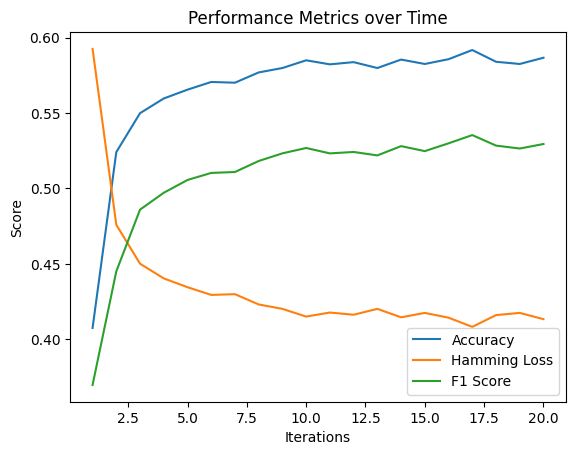

In [ ]:
import matplotlib.pyplot as plt
iterations = range(1, len(accuracy_scores) + 1)

plt.plot(iterations, accuracy_scores, label='Accuracy')
plt.plot(iterations, hamming_scores, label='Hamming Loss')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import entropy

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_pool, X_train, y_pool, y_train = train_test_split(X_train_full, y_train_full, test_size=0.00255, random_state=42)
sample_size = 1000

accuracy_scores = []
hamming_scores = []
f1_scores = []
for iteration in range(20):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    hamming_scores.append(hamming_loss(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy_score(y_test, y_pred):.4f}, Hamming Loss = {hamming_loss(y_test, y_pred)}, F1 = {f1_score(y_test, y_pred, average='weighted')} ")
    sample_size = min(sample_size, len(X_pool))

    probs = clf.predict_proba(X_pool)
    entropies = entropy(probs, axis=1)
    selected_indices = np.argsort(entropies)[-sample_size:]
    X_sample = X_pool[selected_indices]
    try:
        y_sample = y_pool[selected_indices]
    except:
      y_sample = y_pool.iloc[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.concatenate([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)
    if len(X_pool) == 0 or len(X_pool) < sample_size or len(X_train) >= 60000:
        break
print(classification_report(y_test, y_pred))

Iteration 1: Accuracy = 0.4051, Hamming Loss = 0.5949367088607594, F1 = 0.366916295249459 
Iteration 2: Accuracy = 0.5333, Hamming Loss = 0.46665043816942553, F1 = 0.44097464803342357 
Iteration 3: Accuracy = 0.5660, Hamming Loss = 0.434031158714703, F1 = 0.49434738085324204 
Iteration 4: Accuracy = 0.5638, Hamming Loss = 0.436222005842259, F1 = 0.4990012937252985 
Iteration 5: Accuracy = 0.5806, Hamming Loss = 0.4194255111976631, F1 = 0.5263154318144487 
Iteration 6: Accuracy = 0.5815, Hamming Loss = 0.41845180136319376, F1 = 0.5292338147480824 
Iteration 7: Accuracy = 0.5784, Hamming Loss = 0.4216163583252191, F1 = 0.5248977032564499 
Iteration 8: Accuracy = 0.5818, Hamming Loss = 0.41820837390457644, F1 = 0.5213183928443055 
Iteration 9: Accuracy = 0.5796, Hamming Loss = 0.4203992210321324, F1 = 0.5215296674462653 
Iteration 10: Accuracy = 0.5857, Hamming Loss = 0.4143135345666991, F1 = 0.5281174408496105 
Iteration 11: Accuracy = 0.5830, Hamming Loss = 0.4169912366114898, F1 = 0.52

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


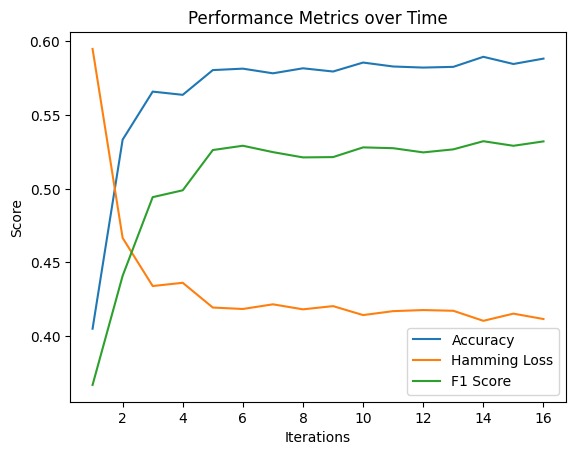

In [ ]:
iterations = range(1, len(accuracy_scores) + 1)

plt.plot(iterations, accuracy_scores, label='Accuracy')
plt.plot(iterations, hamming_scores, label='Hamming Loss')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()

In [ ]:
def margin_sampling(probs):
    sorted_probs = np.sort(probs, axis=1)  # Sort the probabilities for each sample
    margins = sorted_probs[:, -1] - sorted_probs[:, -2]  # Difference between the largest and second largest
    return margins

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_pool, X_train, y_pool, y_train = train_test_split(X_train_full, y_train_full, test_size=0.00255, random_state=42)
sample_size = 1000
accuracy_scores = []
hamming_scores = []
f1_scores = []
for iteration in range(20):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    hamming_scores.append(hamming_loss(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
    print(f"Iteration {iteration + 1}: Accuracy = {accuracy_score(y_test, y_pred):.4f}, Hamming Loss = {hamming_loss(y_test, y_pred)}, F1 = {f1_score(y_test, y_pred, average='weighted')} ")
    sample_size = min(sample_size, len(X_pool))

    probs = clf.predict_proba(X_pool)
    margins = margin_sampling(probs)
    selected_indices = np.argsort(margins)[:sample_size]
    X_sample = X_pool[selected_indices]
    try:
        y_sample = y_pool[selected_indices]
    except:
      y_sample = y_pool.iloc[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.concatenate([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)
    if len(X_pool) == 0 or len(X_pool) < sample_size or len(X_train) >= 60000:
        break
print(classification_report(y_test, y_pred))

Iteration 1: Accuracy = 0.4065, Hamming Loss = 0.5934761441090555, F1 = 0.3701968105991995 
Iteration 2: Accuracy = 0.5368, Hamming Loss = 0.46324245374878287, F1 = 0.466127384080765 
Iteration 3: Accuracy = 0.5767, Hamming Loss = 0.4233203505355404, F1 = 0.5271364536082377 
Iteration 4: Accuracy = 0.5701, Hamming Loss = 0.4298928919182084, F1 = 0.524118685256363 
Iteration 5: Accuracy = 0.5777, Hamming Loss = 0.4223466407010711, F1 = 0.5343436648955985 
Iteration 6: Accuracy = 0.5837, Hamming Loss = 0.4162609542356378, F1 = 0.5401467525853942 
Iteration 7: Accuracy = 0.5852, Hamming Loss = 0.4148003894839338, F1 = 0.5387235115823943 
Iteration 8: Accuracy = 0.5898, Hamming Loss = 0.41017526777020447, F1 = 0.5462611191796912 
Iteration 9: Accuracy = 0.5893, Hamming Loss = 0.4106621226874391, F1 = 0.5416169751210621 
Iteration 10: Accuracy = 0.5845, Hamming Loss = 0.41553067185978576, F1 = 0.5382070537396421 
Iteration 11: Accuracy = 0.5852, Hamming Loss = 0.4148003894839338, F1 = 0.537

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


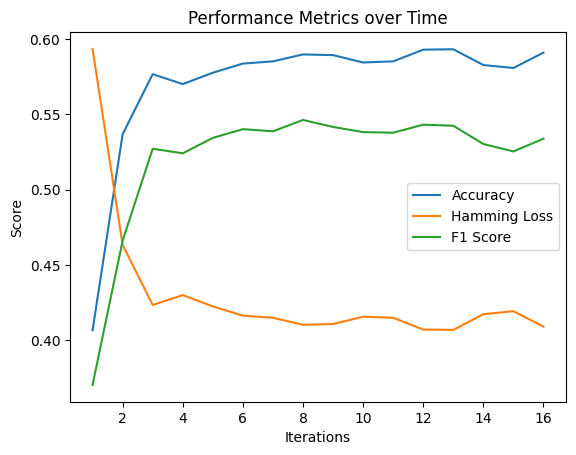

In [ ]:
iterations = range(1, len(accuracy_scores) + 1)

plt.plot(iterations, accuracy_scores, label='Accuracy')
plt.plot(iterations, hamming_scores, label='Hamming Loss')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()

##### Test with Random for Multilabel

In [ ]:
hamming_loss_scores = []
jaccard_scores = []
f1_scores = []
for iteration in range(iterations):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    hamming_loss_scores.append(hamming_loss(y_test, y_pred))
    jaccard_scores.append(jaccard_score(y_test, y_pred, average='samples'))
    f1_scores.append(f1_score(y_test, y_pred, average='micro'))
    print(f"Iteration {iteration + 1}: Loss = {hamming_loss(y_test, y_pred):.4f}, Jaccard_Score = {jaccard_score(y_test, y_pred, average='samples')}, F1 = {f1_score(y_test, y_pred, average='micro')} ")
    sample_size = min(sample_size, len(X_pool))
    selected_indices = np.random.choice(len(X_pool), size=sample_size, replace=False)
    X_sample = X_pool[selected_indices]
    y_sample = y_pool[selected_indices]
    X_train = np.vstack([X_train, X_sample])
    y_train = np.vstack([y_train, y_sample])
    X_pool = np.delete(X_pool, selected_indices, axis=0)
    y_pool = np.delete(y_pool, selected_indices, axis=0)

y_pred = clf.predict(X_test)
print(f"Final Scores: Loss = {hamming_loss(y_test, y_pred):.4f}, Jaccard_Score = {jaccard_score(y_test, y_pred, average='samples')}, F1 = {f1_score(y_test, y_pred, average='micro')} ")

Iteration 1: Loss = 0.0711, Jaccard_Score = 0.26350235099758545, F1 = 0.3354502672819482 
Iteration 2: Loss = 0.0722, Jaccard_Score = 0.26002668699961873, F1 = 0.32621979024167813 
Iteration 3: Loss = 0.0731, Jaccard_Score = 0.2551340704028466, F1 = 0.3203671725892938 
Iteration 4: Loss = 0.0736, Jaccard_Score = 0.25114584657093236, F1 = 0.31502798125483417 
Iteration 5: Loss = 0.0740, Jaccard_Score = 0.24725293345194221, F1 = 0.31135164635255597 
Iteration 6: Loss = 0.0742, Jaccard_Score = 0.25038971491506756, F1 = 0.3135482121061435 
Iteration 7: Loss = 0.0744, Jaccard_Score = 0.2519252764010675, F1 = 0.31446597566471385 
Iteration 8: Loss = 0.0748, Jaccard_Score = 0.24804930740881942, F1 = 0.3101941528897698 
Iteration 9: Loss = 0.0749, Jaccard_Score = 0.24914008556784004, F1 = 0.3118154067157479 
Iteration 10: Loss = 0.0753, Jaccard_Score = 0.24637607489304017, F1 = 0.30770613345315656 


ValueError: Found input variables with inconsistent numbers of samples: [78843, 7869]

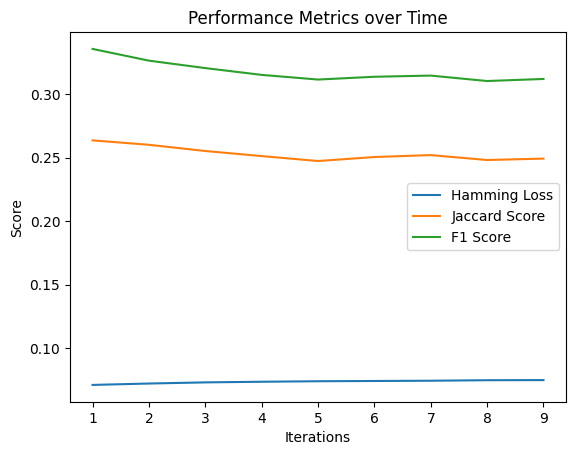

In [ ]:
import matplotlib.pyplot as plt
iterations = range(1, len(hamming_loss_scores) + 1)

plt.plot(iterations, hamming_loss_scores, label='Hamming Loss')
plt.plot(iterations, jaccard_scores, label='Jaccard Score')
plt.plot(iterations, f1_scores, label='F1 Score')

plt.xlabel('Iterations')
plt.ylabel('Score')
plt.title('Performance Metrics over Time')
plt.legend()
plt.show()